# EAS: Predicción

## Preparación de datos

Una vez terminado el entrenamiento comienza el proceso de predicción. En este caso se puede ejecutar iterativamente por cada remesa 

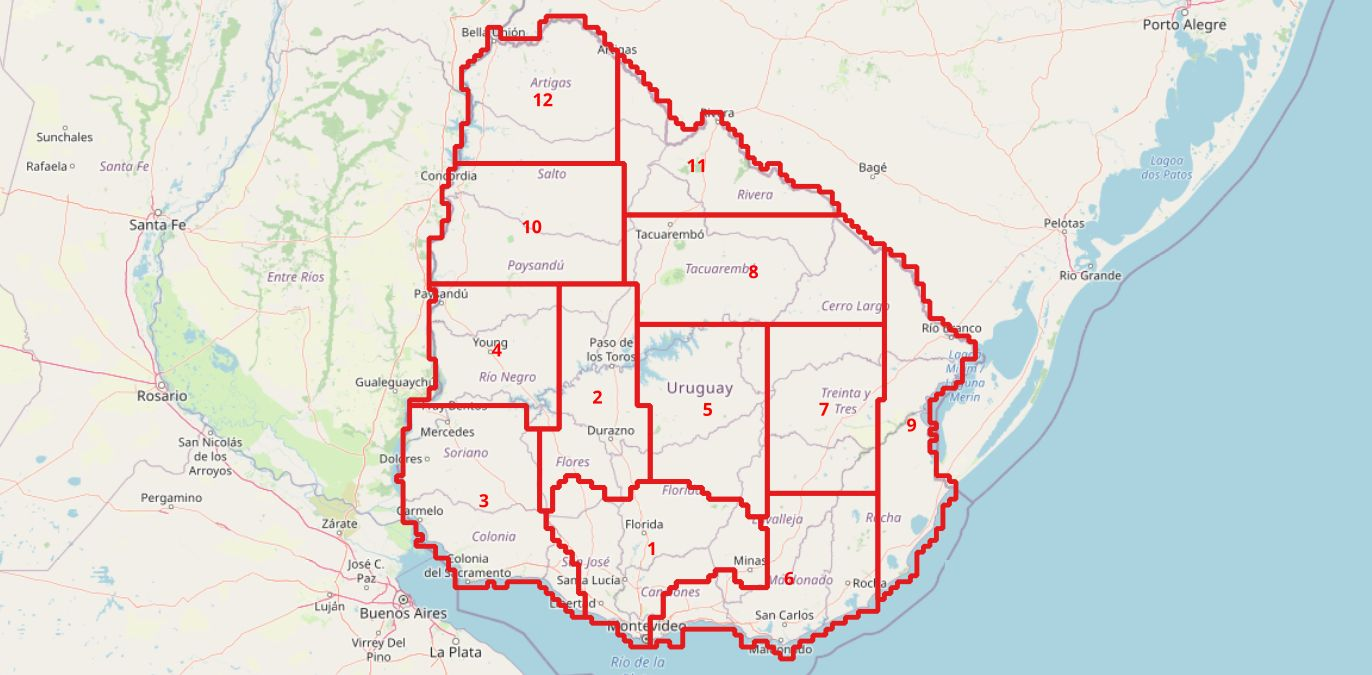

In [5]:
from IPython.display import Image
Image("/home/ro/meduy-cqc/img/remesas.jpg")

De modo similar primero debemos generar el buffer de los caminos

In [8]:
!ogr2ogr -t_srs epsg:5382 data/shp/caminos_lineas_5382.geojson data/shp/caminos_lineas.geojson -f GeoJSON #cambia el epsg a 5382 para que luego el buffer pueda ser en mts

In [13]:
!ogrinfo -so data/shp/caminos_lineas_5382.geojson

INFO: Open of `data/shp/caminos_lineas_5382.geojson'
      using driver `GeoJSON' successful.
1: caminos_leneas (Multi Line String)


In [12]:
!ogr2ogr -f GeoJSON -sql "SELECT ST_BUFFER(geometry , 7) as geometry,id, tipo_pav FROM caminos_leneas" -dialect sqlite  data/shp/caminos_polig_5382.geojson data/shp/caminos_lineas_5382.geojson 

ERROR 1: In ExecuteSQL(): sqlite3_prepare_v2(SELECT ST_BUFFER(geometry , 7) as geometry,id, tipo_pav FROM caminos_leneas):
  no such column: id


## Preprocesamiento

En el caso de la predicción no se deben generar las máscaras, y el step-size debe ser del mismo valor que la imagen para que no exista overlap en los resultados.
Se ejecuta del siguiente modo:

In [ ]:
#!meduy_extract_chips /tmp/imagenes/*Remesa12*.jpg -o data/data_predict/400_400/Remesa12/ --size 400 --step-size 400 --crs epsg:5382 --aoi data/shp/caminos_pred.geojson --skip-existing

 (--skip-existing en caso de correr el script mas de una vez skip-existing evita volver a generar chips ya existentes)

* Obs: caminos_pred.geojson ya posee el buffer

## Predicción

In [6]:
from meduy.unet.predict import PredictConfig, predict
import os

In [7]:
#REMESAS = ['Remesa01','Remesa02','Remesa03','Remesa04','Remesa05','Remesa06','Remesa07','Remesa08','Remesa09','Remesa10','Remesa11','Remesa12',]

REMESAS = ['Remesa12']#,'Remesa02','Remesa01','Remesa10','Remesa11',]

for remesa in REMESAS: 
    predict_config = PredictConfig(
        images_path=os.path.join('./data/data_predict', '400_400', remesa), # ruta a las imagenes sobre las cuales queremos predecir
        results_path=os.path.join('./data/data_results', '400_400'), # ruta de destino para nuestra predicción
        batch_size=32,
        model_path=os.path.join('./weights/', 'UNet_caminos_400-200_spe100.h5'),  #  ruta al modelo (.h5)
        height=320,
        width=320,
        n_channels=3,
        n_classes=4)

    predict(predict_config)  # Ejecuta la predicción

100%|██████████| 1049/1049 [29:33<00:00,  1.69s/it]

Done!


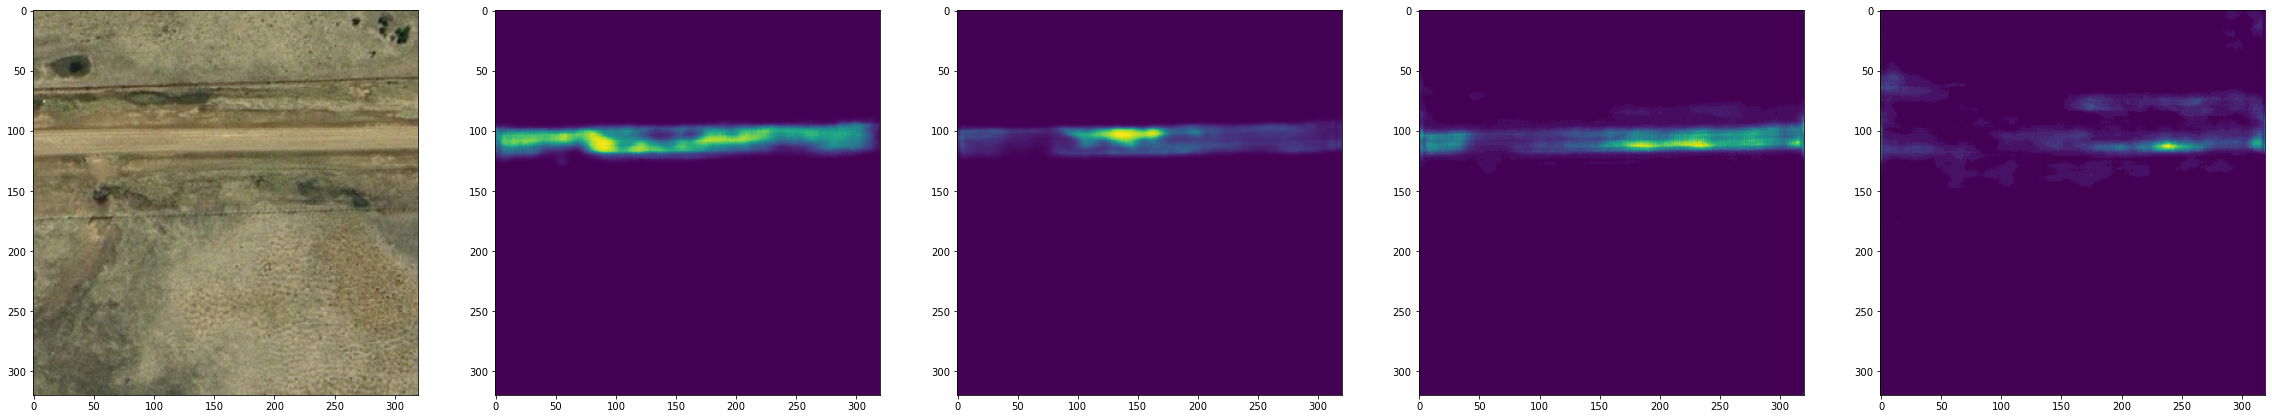

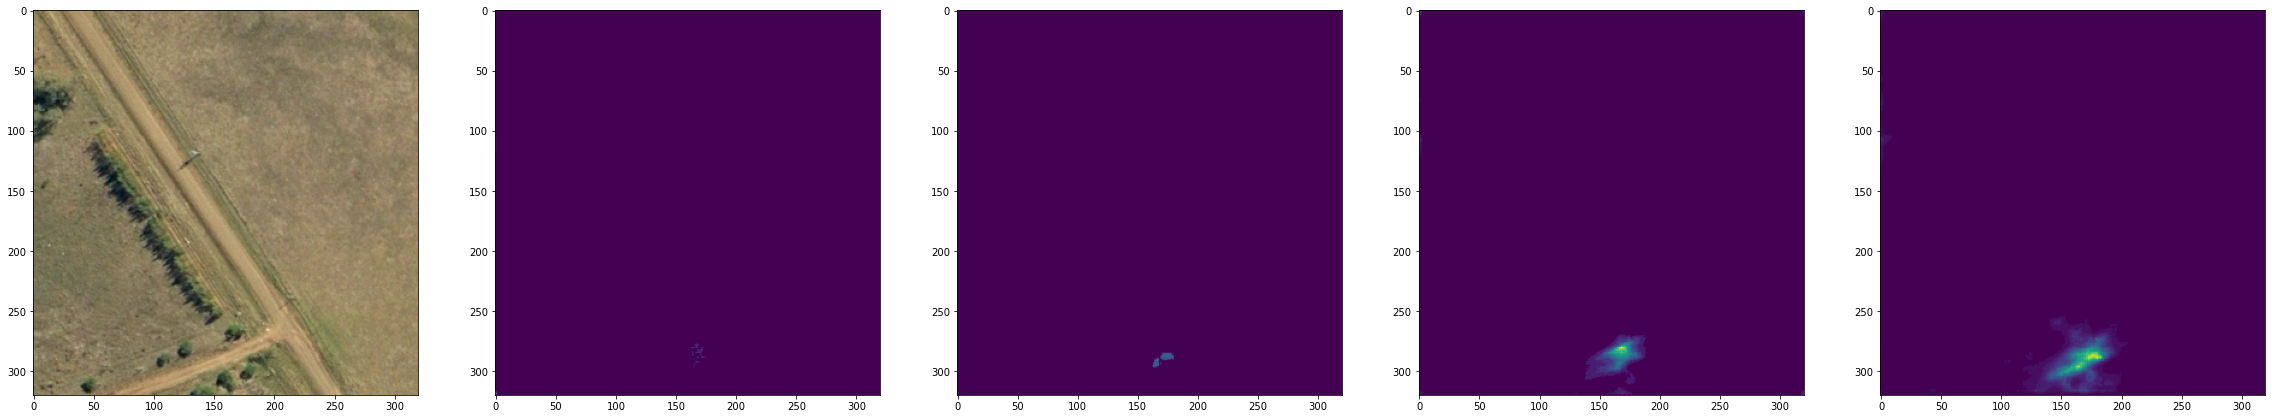

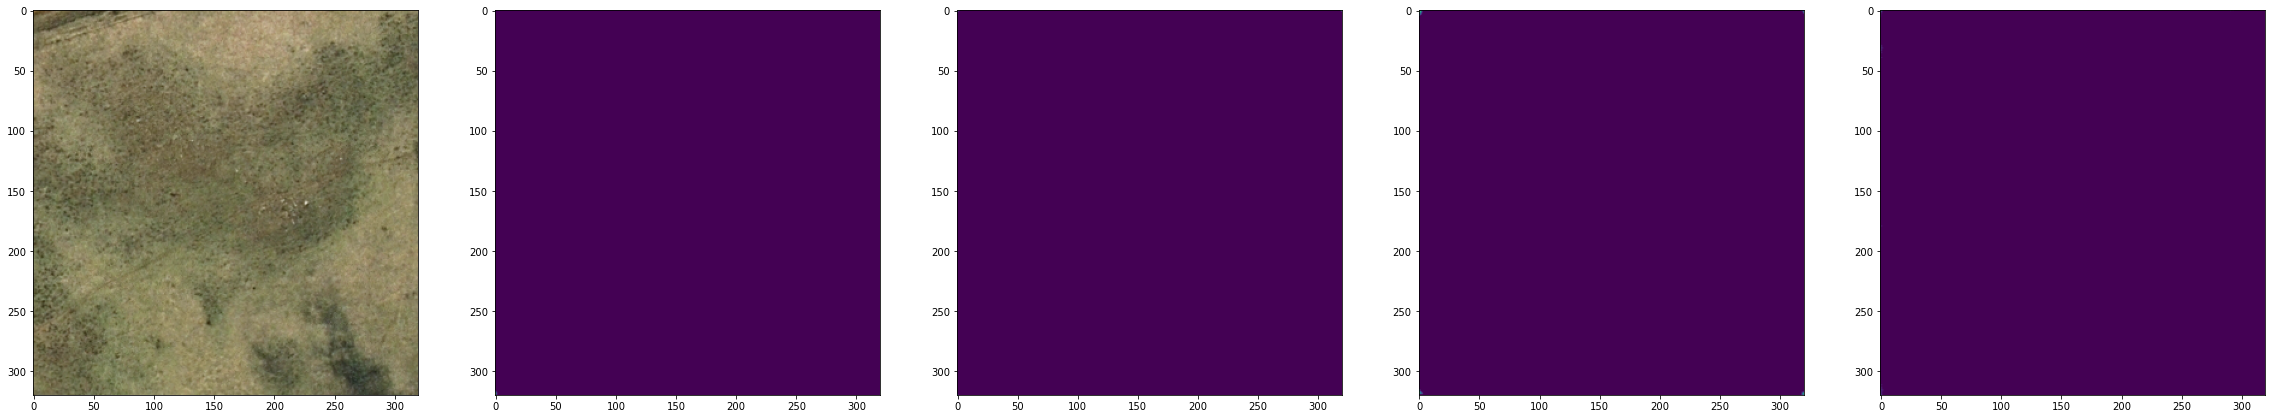

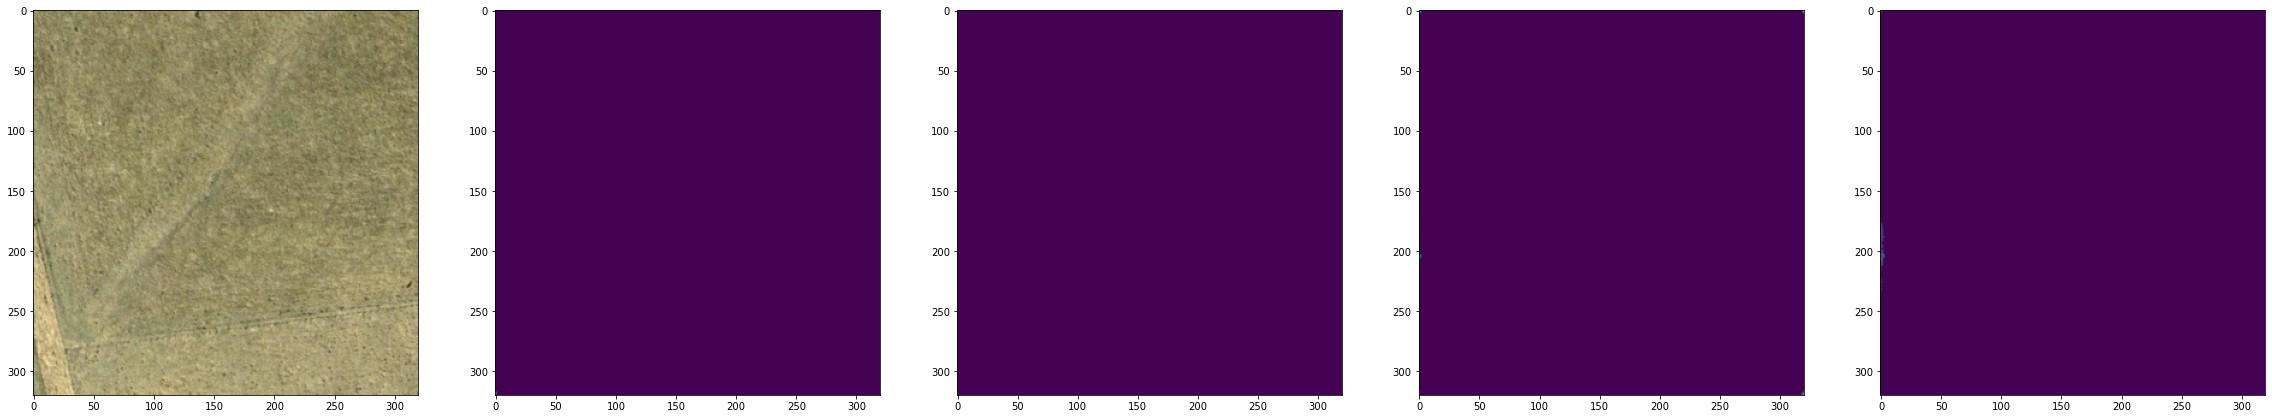

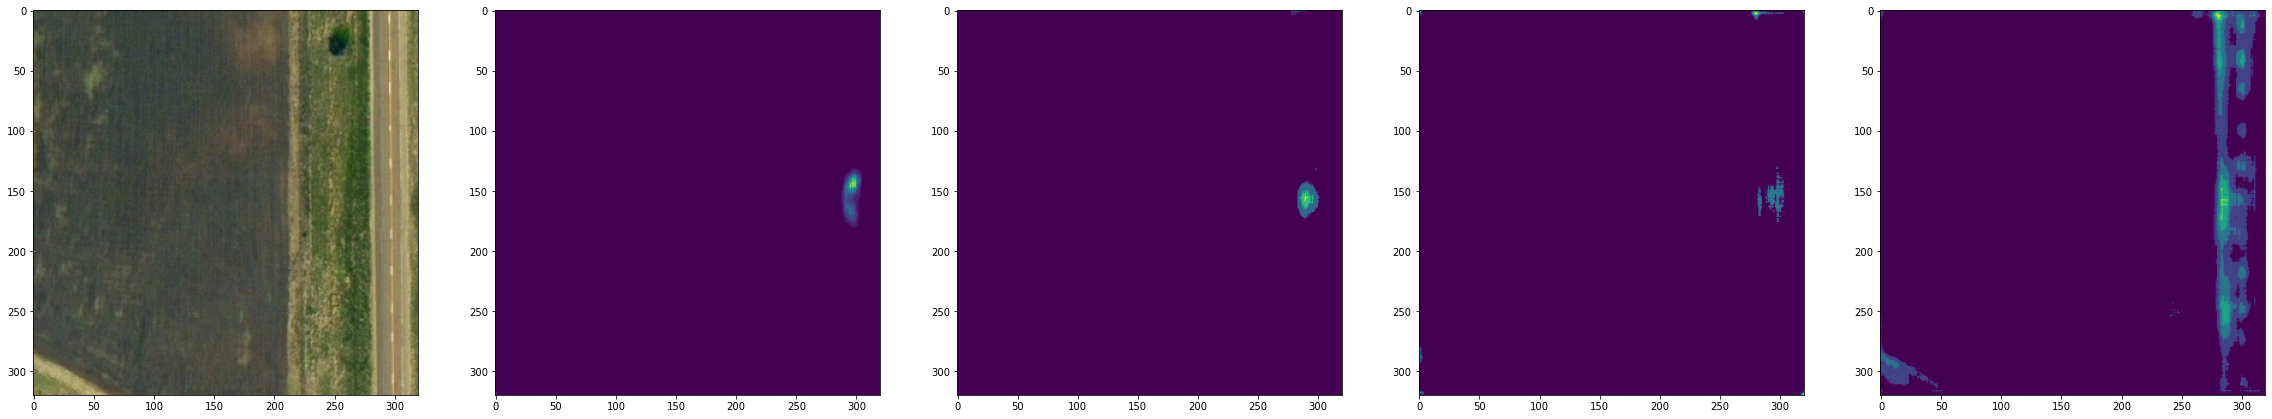

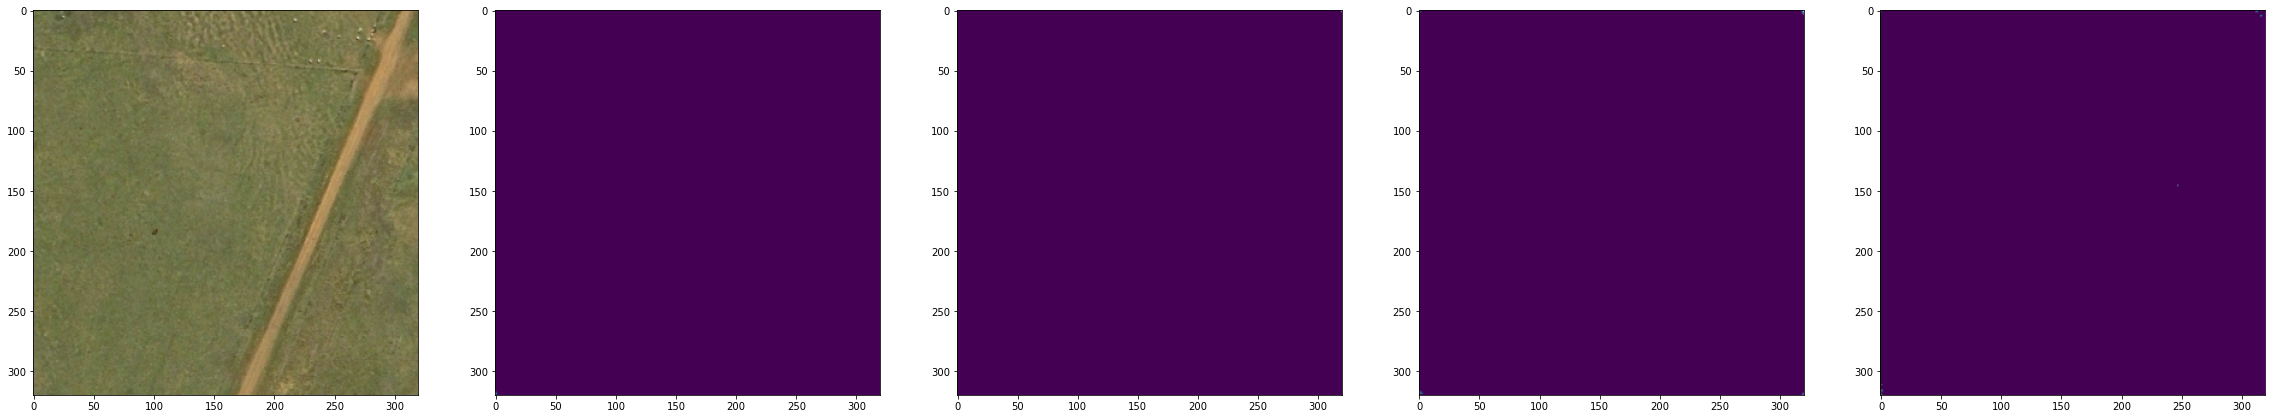

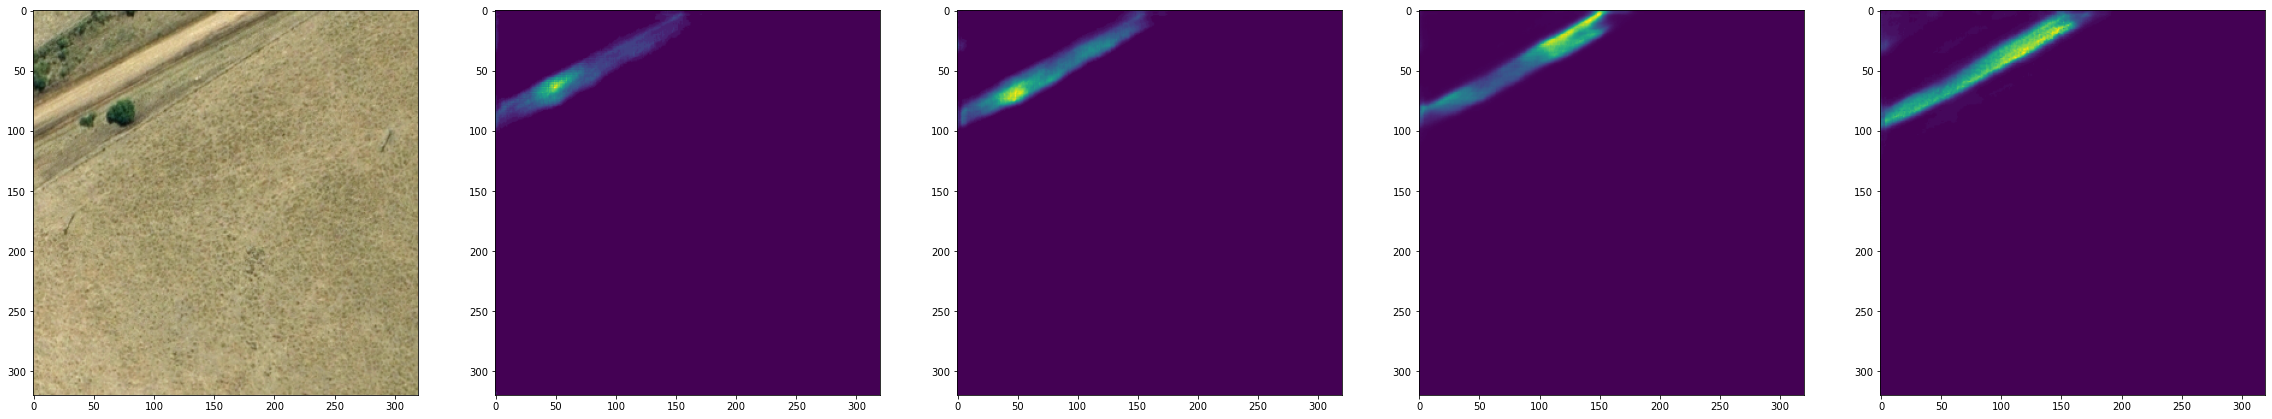

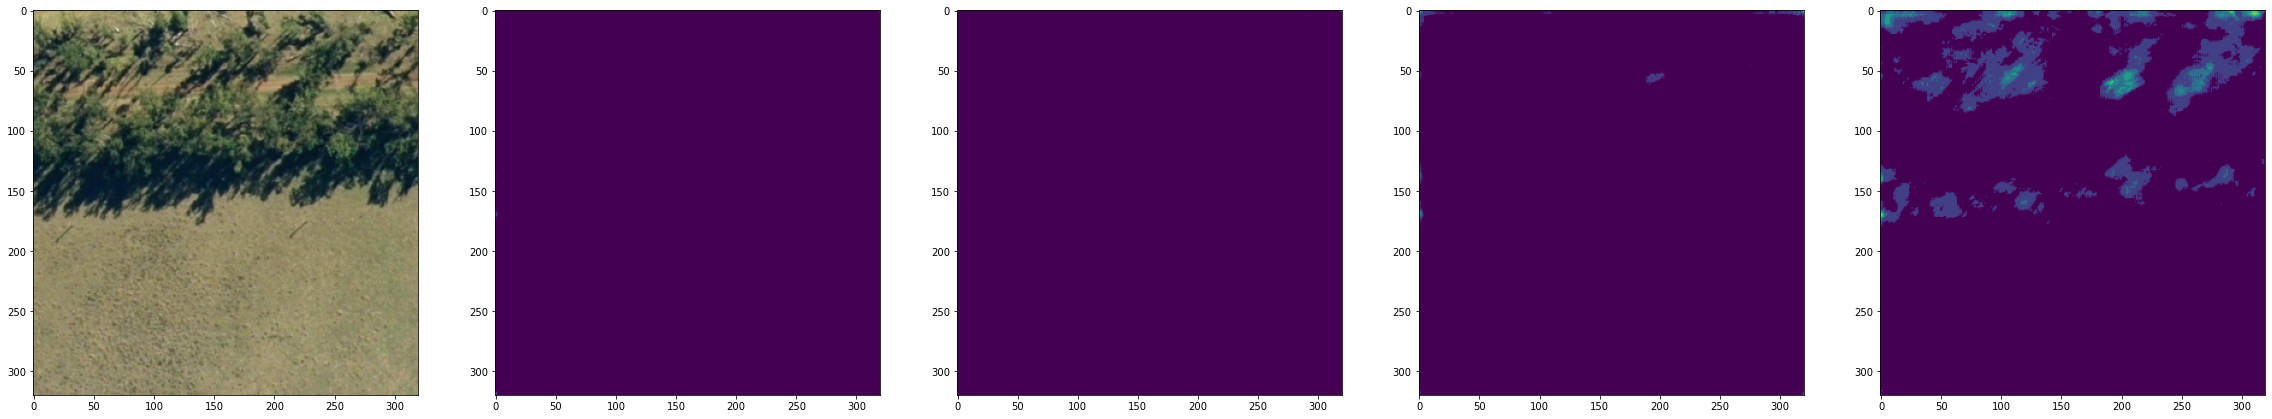

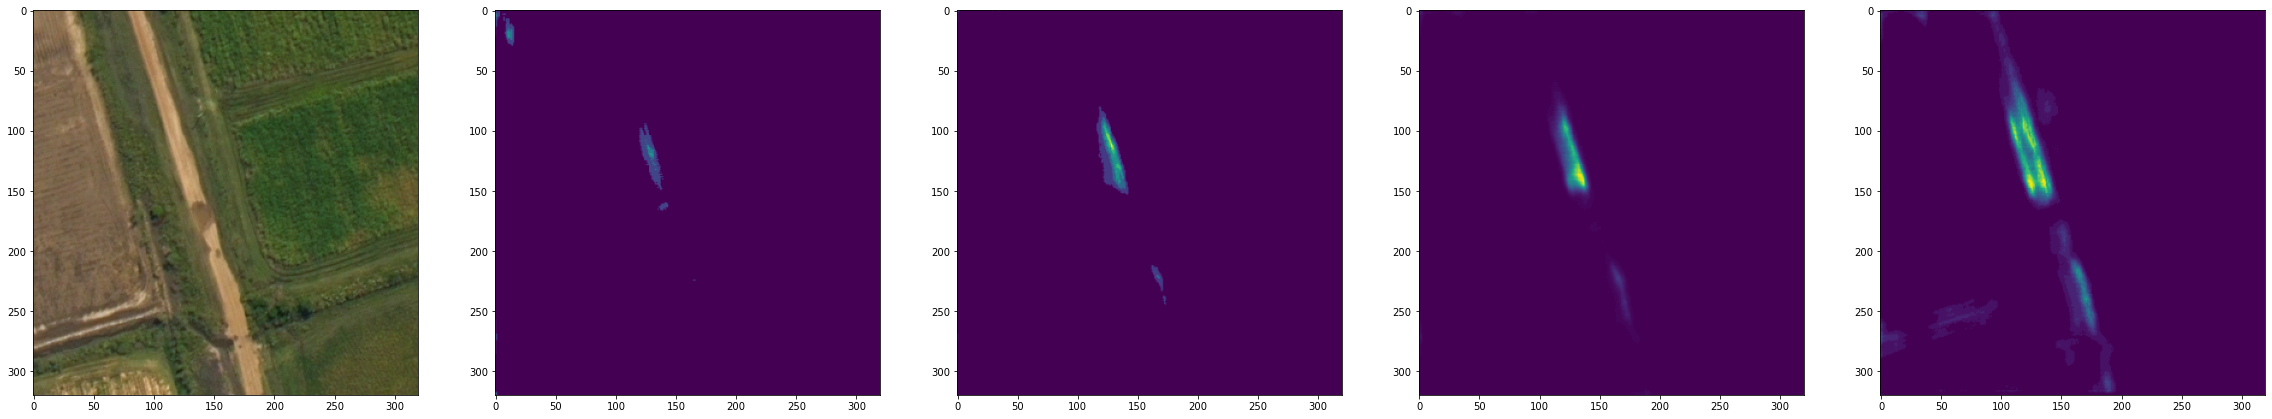

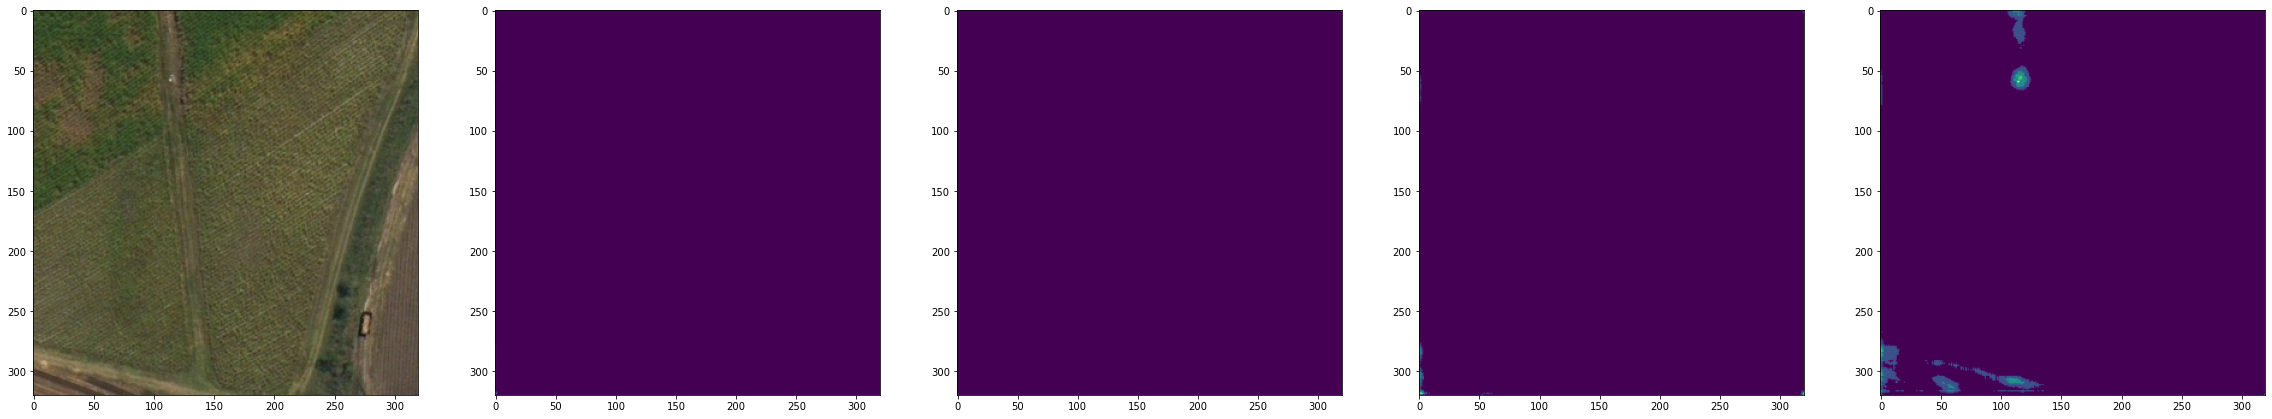

In [15]:
import tifffile as tiff
from skimage.transform import resize
from sklearn.preprocessing import minmax_scale
import matplotlib.pyplot as plt
import random
import numpy as np
from glob import glob

H = 10
images_path=os.path.join('./data/data_train', '400_200')
images = [os.path.basename(f) for f in sorted(glob(os.path.join(predict_config.images_path, 'images', '*.tif')))]

# Sample
#images = images[:H] 
images = random.sample(images, H)

for img_file in images:
    try:
        img_ = tiff.imread(os.path.join(predict_config.images_path, 'images', img_file))[:,:,:predict_config.n_channels]
        img_ = minmax_scale(img_.ravel(), feature_range=(0, 255)).reshape(img_.shape)
        img_ = resize(img_, (predict_config.height, predict_config.width), mode='constant', preserve_range=True).astype(np.uint8)

        
        # Prediccion
        mask_ = tiff.imread(os.path.join(predict_config.results_path, img_file)) / 255
        mask_ = resize(mask_, (predict_config.height, predict_config.width), mode='constant', preserve_range=True)    

        fig, axes = plt.subplots(nrows=1, ncols=predict_config.n_classes + 1 , figsize=(predict_config.n_classes * 10, 20)) 
        axes[0].imshow(img_)
      
        for c in range(0, predict_config.n_classes):
            axes[1+c].imshow(np.squeeze(mask_[:,:,c]))
        
        plt.show()
        print("=================================================================================")
    except Exception as err:
        print(err)